# Pandas 3:  Shaping data  

The second in a series of notebooks that describe Pandas' powerful data management tools.  This one covers shaping methods:  switching rows and columns, pivoting, and stacking.  We'll see that this is all about the indexes:  the row and column labels.  

Outline:  

* [Example:  WEO debt and deficits](#wants).  Something to work with.  
* [Indexing](#index).  Setting and resetting the index.  Multi-indexes. 
* [Switching rows and columns](#pivot).  Transpose.  Referring to variables with multi-indexes.  
* [Stack and unstack](#stack).  Managing column structure and labels.  
* [Pivot](#pivot).  Unstack shortcut if we start with wide data. 
* [Review](#review).  Apply what we've learned.  

More data management topics coming.  

**Note: requires internet access to run.**  

<!-- 
internal links http://sebastianraschka.com/Articles/2014_ipython_internal_links.html
-->

This IPython notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/).  

<a id=prelims></a>

## Preliminaries 

Import packages, etc.  

In [1]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas 

%matplotlib inline                     

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Today:  2016-04-12


<a id=wants></a>

## Example:  WEO debt and deficits 

We spend most of our time on one of the examples from the previous notebook. The problem in this example is that variables run across rows, rather than down columns.  Our **want** is to flip some of the rows and columns so that we can plot the data against time.  The question is how.

We use a small subset of the IMF's [World Economic Outlook database](https://www.imf.org/external/ns/cs.aspx?id=28) that contains two variables and three countries.  

In [2]:
url1 = 'http://www.imf.org/external/pubs/ft/weo/2015/02/weodata/'
url2 = 'WEOOct2015all.xls'
url = url1 + url2 
weo = pd.read_csv(url, sep='\t', 
                  usecols=[1,2,3,4,6,40,41,42], 
                  thousands=',', 
                  na_values=['n/a', '--']) 
print('Variable dtypes:\n', weo.dtypes, sep='')

Variable dtypes:
ISO                    object
WEO Subject Code       object
Country                object
Subject Descriptor     object
Units                  object
2011                  float64
2012                  float64
2013                  float64
dtype: object


In [3]:
# create debt and deficits dataframe:  two variables and three countries 
variables = ['GGXWDG_NGDP', 'GGXCNL_NGDP']
countries = ['ARG', 'DEU', 'GRC']
dd = weo[weo['WEO Subject Code'].isin(variables) & weo['ISO'].isin(countries)]

# change column labels to something more intuitive 
dd = dd.rename(columns={'WEO Subject Code': 'Variable', 
                        'Subject Descriptor': 'Description'})

# rename variables 
dd['Variable'] = dd['Variable'].replace(to_replace=['GGXWDG_NGDP', 'GGXCNL_NGDP'], 
                                        value=['Debt', 'Surplus'])
dd

,ISO,Variable,Country,Description,Units,2011,2012,2013
252,ARG,Surplus,Argentina,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
260,ARG,Debt,Argentina,General government gross debt,Percent of GDP,35.763,37.328,40.217
2716,DEU,Surplus,Germany,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
2724,DEU,Debt,Germany,General government gross debt,Percent of GDP,77.928,79.311,76.978
2804,GRC,Surplus,Greece,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
2812,GRC,Debt,Greece,General government gross debt,Percent of GDP,170.960,156.494,174.951


**Wants.** We might imagine doing several different things with this data:

* Plot a specific variable (debt or surplus) for a given date. 
* Time series plots for a specific country.
* Time series plots for a specific variable.  

Depending on which we want, we might organize the data differently.  We'll focus on the last two.  

Here's a brute force approach to the problem:  simply transpose the data.  This is where that leads:  

In [4]:
dd.T

,252,260,2716,2724,2804,2812
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
2011,-1.949,35.763,-0.861,77.928,-10.215,170.96
2012,-2.359,37.328,0.091,79.311,-6.406,156.494
2013,-1.997,40.217,0.133,76.978,-2.944,174.951


**Comments.** The problem here is that the columns include both the numbers (which we want to plot) and some descriptive information (which we don't).  

<a id='index'></a>

## Setting and resetting the index

We start by setting and resetting the index.  That may sound like a step backwards -- haven't we done this already? -- but it reminds us of some things that will be handy later.  

Take the dataframe `dd`.  What would we like in the index?  Evenutally we'd like the dates `[2011, 2012, 2013]`, but right now the row labels are more naturally the variable or country.  Here are some varriants.  

### Setting the index

In [18]:
dd.set_index('Country')

,ISO,Variable,Description,Units,2011,2012,2013
Country,,,,,,,
Argentina,ARG,Surplus,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
Argentina,ARG,Debt,General government gross debt,Percent of GDP,35.763,37.328,40.217
Germany,DEU,Surplus,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
Germany,DEU,Debt,General government gross debt,Percent of GDP,77.928,79.311,76.978
Greece,GRC,Surplus,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
Greece,GRC,Debt,General government gross debt,Percent of GDP,170.960,156.494,174.951


In [19]:
# we can do the same thing with a list, which will be meaningful soon...
dd.set_index(['Country'])

,ISO,Variable,Description,Units,2011,2012,2013
Country,,,,,,,
Argentina,ARG,Surplus,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
Argentina,ARG,Debt,General government gross debt,Percent of GDP,35.763,37.328,40.217
Germany,DEU,Surplus,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
Germany,DEU,Debt,General government gross debt,Percent of GDP,77.928,79.311,76.978
Greece,GRC,Surplus,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
Greece,GRC,Debt,General government gross debt,Percent of GDP,170.960,156.494,174.951


**Exercise.** Set `Variable` as the index.  

**Comment.** You may have noticed something.  The new index brought with it its **name**:  `Country` in the two examples, `Variable` in the exercise.  That's incredibly useful because we can refer to index levels by name.  

### Multi-indexes

We can put more than one variable in an index, which gives us a **multi-index**.  This is sometimes called a **hierarchical index** because the **levels** of the index (as they're called) are ordered. 

Multi-indexes are more common than you might think.  One reason is that data itself is often multi-dimensional.  A typical spreadsheet has two dimensions:  the variable and the observation.  The WEO data is naturally three dimensional:  the variable, the year, and the country.  (Think about that for a minute, it's deeper than it sounds.) 

The problem we're having is fitting this nicely into two dimensions.  A multi-index allows us to manage that. 

**Example.** We push all the descriptive columns into the index, leaving the dataframe itself with only numbers, which seems like a step in thee right direction.  

In [20]:
ddi = dd.set_index(['Variable', 'Country', 'ISO', 'Description', 'Units'])
ddi

,,,,,2011,2012,2013
Variable,Country,ISO,Description,Units,,,
Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
Debt,Argentina,ARG,General government gross debt,Percent of GDP,35.763,37.328,40.217
Surplus,Germany,DEU,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
Debt,Germany,DEU,General government gross debt,Percent of GDP,77.928,79.311,76.978
Surplus,Greece,GRC,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
Debt,Greece,GRC,General government gross debt,Percent of GDP,170.960,156.494,174.951


Let's take a closer look at the index

In [21]:
ddi.index

MultiIndex(levels=[['Debt', 'Surplus'], ['Argentina', 'Germany', 'Greece'], ['ARG', 'DEU', 'GRC'], ['General government gross debt', 'General government net lending/borrowing'], ['Percent of GDP']],
           labels=[[1, 0, 1, 0, 1, 0], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0]],
           names=['Variable', 'Country', 'ISO', 'Description', 'Units'])

That's a lot to process, so we break it into pieces.  

* `ddi.index.names` contains a list of level names.  (Remind yourself that lists are ordered, so this tracks levels.)
* `ddi.index.levels` contains the values in each level.  

Here's what they like like here:  

In [22]:
# recall that Chase and Spencer like double quotes 
print("The level names are:\n", ddi.index.names, '\n', sep='')
print("The levels are:\n", ddi.index.levels, sep='')

The level names are:
['Variable', 'Country', 'ISO', 'Description', 'Units']

The levels are:
[['Debt', 'Surplus'], ['Argentina', 'Germany', 'Greece'], ['ARG', 'DEU', 'GRC'], ['General government gross debt', 'General government net lending/borrowing'], ['Percent of GDP']]


Knowing the order of the levels and being able to inspect their values and names is fundamental to working with a multi-index.

### Resetting the index

We've seen that `set_index` pushes columns into the index.  Here we see that `reset_index` does the reverse:  it pushes components of the index back to the columns.  

**Example.** 

In [23]:
ddi

,,,,,2011,2012,2013
Variable,Country,ISO,Description,Units,,,
Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
Debt,Argentina,ARG,General government gross debt,Percent of GDP,35.763,37.328,40.217
Surplus,Germany,DEU,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
Debt,Germany,DEU,General government gross debt,Percent of GDP,77.928,79.311,76.978
Surplus,Greece,GRC,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
Debt,Greece,GRC,General government gross debt,Percent of GDP,170.960,156.494,174.951


In [24]:
ddi.reset_index()

,Variable,Country,ISO,Description,Units,2011,2012,2013
0,Surplus,Argentina,ARG,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997
1,Debt,Argentina,ARG,General government gross debt,Percent of GDP,35.763,37.328,40.217
2,Surplus,Germany,DEU,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133
3,Debt,Germany,DEU,General government gross debt,Percent of GDP,77.928,79.311,76.978
4,Surplus,Greece,GRC,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944
5,Debt,Greece,GRC,General government gross debt,Percent of GDP,170.960,156.494,174.951


In [25]:
# or we can reset the index level by level
ddi.reset_index(level=1)

,,,,Country,2011,2012,2013
Variable,ISO,Description,Units,,,,
Surplus,ARG,General government net lending/borrowing,Percent of GDP,Argentina,-1.949,-2.359,-1.997
Debt,ARG,General government gross debt,Percent of GDP,Argentina,35.763,37.328,40.217
Surplus,DEU,General government net lending/borrowing,Percent of GDP,Germany,-0.861,0.091,0.133
Debt,DEU,General government gross debt,Percent of GDP,Germany,77.928,79.311,76.978
Surplus,GRC,General government net lending/borrowing,Percent of GDP,Greece,-10.215,-6.406,-2.944
Debt,GRC,General government gross debt,Percent of GDP,Greece,170.960,156.494,174.951


In [26]:
ddi.reset_index(level=[1,3])

,,,Country,Description,2011,2012,2013
Variable,ISO,Units,,,,,
Surplus,ARG,Percent of GDP,Argentina,General government net lending/borrowing,-1.949,-2.359,-1.997
Debt,ARG,Percent of GDP,Argentina,General government gross debt,35.763,37.328,40.217
Surplus,DEU,Percent of GDP,Germany,General government net lending/borrowing,-0.861,0.091,0.133
Debt,DEU,Percent of GDP,Germany,General government gross debt,77.928,79.311,76.978
Surplus,GRC,Percent of GDP,Greece,General government net lending/borrowing,-10.215,-6.406,-2.944
Debt,GRC,Percent of GDP,Greece,General government gross debt,170.960,156.494,174.951


**Comment.** By default, `reset_index` pushes one or more index levels into columns.  If we want to discard that level of the index altogether, we use the parameter `drop=True`.  

In [27]:
ddi.reset_index(level=[1,3], drop=True)

,,,2011,2012,2013
Variable,ISO,Units,,,
Surplus,ARG,Percent of GDP,-1.949,-2.359,-1.997
Debt,ARG,Percent of GDP,35.763,37.328,40.217
Surplus,DEU,Percent of GDP,-0.861,0.091,0.133
Debt,DEU,Percent of GDP,77.928,79.311,76.978
Surplus,GRC,Percent of GDP,-10.215,-6.406,-2.944
Debt,GRC,Percent of GDP,170.960,156.494,174.951


We can also refer to levels by their `name` when operating on the index. Here's an example with `reset_index`:

In [28]:
ddi.reset_index(level=["ISO", "Description"], drop=True)

,,,2011,2012,2013
Variable,Country,Units,,,
Surplus,Argentina,Percent of GDP,-1.949,-2.359,-1.997
Debt,Argentina,Percent of GDP,35.763,37.328,40.217
Surplus,Germany,Percent of GDP,-0.861,0.091,0.133
Debt,Germany,Percent of GDP,77.928,79.311,76.978
Surplus,Greece,Percent of GDP,-10.215,-6.406,-2.944
Debt,Greece,Percent of GDP,170.960,156.494,174.951


**Exercise.**  For the dataframe `ddi`:  

* Use the `reset_index` method to move the `Units` level of the index to a column of the dataframe.
* Use the `drop` parameter of `reset_index` to delete `Units` from the dataframe.  

## Switching rows and columns   

If we take the dataframe `ddi`, we see that the everything's been put into the index but the data itself.  Perhaps we can get what we want if we just flip the rows and columns.  

### First look at switching rows and columns 

Here we can use the `T` or transpose property.  When we do that, we end up with a lot of stuff in the column labels, as the multi-index for the rows gets rotated into the columns.  Other than that, we're good. We can even do a plot.  The only problem is that all the stuff we've pushed into the column labels -- it's kind of a mess.  

In [29]:
ddt = ddi.T
ddt

Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
2011,-1.949,35.763,-0.861,77.928,-10.215,170.960
2012,-2.359,37.328,0.091,79.311,-6.406,156.494
2013,-1.997,40.217,0.133,76.978,-2.944,174.951


**Comment.** We see here that the multi-index for the rows has been turned into a multi-index for the columns.  Works the same way.  

The only problem here is that the column labels are more complicated than we might want.  Here, for example, is what we get with the plot method.  As usual, `.plot()` plots all the columns of the dataframe, but here that means we're mixing variables.  And the legend contains the complete set of column labels.  

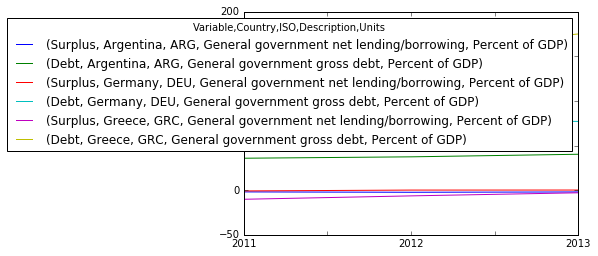

In [31]:
ddt.plot()

### Referring to variables with a multi-index

Can we refer to variables in the same way?  Sort of, as long as we refer to the top level of the column index.  It gives us a dataframe that's a subset of the original one.  

Let's try each of these:  

* `ddt['Debt']`
* `ddt['Surplus']`
* `ddt['ARG']`

What do you see?  What's going on?  The theme is that we can reference the top level, which in `ddi` is the `Variable`.  If we try to access a lower level, it bombs.  

In [32]:
# indexing by variable 
debt = ddt['Debt']
print('debt has type', type(debt))
debt 

debt has type <class 'pandas.core.frame.DataFrame'>


Country,Argentina,Germany,Greece
ISO,ARG,DEU,GRC
Description,General government gross debt,General government gross debt,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP
2011,35.763,77.928,170.960
2012,37.328,79.311,156.494
2013,40.217,76.978,174.951


**Exercise.** With the dataframe `ddt`: 

* What type of object is `Debt`? 
* Construct a line plot of `Debt` over time with one line for each country.  

**Example.** Let's do this together.  How would we fix up the legend?  What approaches cross your mind?  (No code, just the general approach.) 

### Swapping levels

Since variables refer to the first level of the column index, it's not clear how we would group data by country.  Suppose, for example, we wanted to plot `Debt` and `Surplus` for a specific country.  What would we do?  

One way to do that is to make the country the top level with the `swaplevel` method.  Note the `axis` parameter.  With `axis=1` we swap column levels, with `axis=0` (the default) we swap row levels.  

In [33]:
ddts = ddt.swaplevel(0,1, axis=1) 
ddts

Country                                    Argentina  \
Variable                                     Surplus   
ISO                                              ARG   
Description General government net lending/borrowing   
Units                                 Percent of GDP   
2011                                          -1.949   
2012                                          -2.359   
2013                                          -1.997   

Country                                    \
Variable                             Debt   
ISO                                   ARG   
Description General government gross debt   
Units                      Percent of GDP   
2011                               35.763   
2012                               37.328   
2013                               40.217   

Country                                      Germany  \
Variable                                     Surplus   
ISO                                              DEU   
Description General government net lending/borrowing   
Units                                 Percent of GDP   
2011                                          -0.861   
2012                                           0.091   
2013                                           0.133   

Country                                    \
Variable                             Debt   
ISO                                   DEU   
Description General government gross debt   
Units                      Percent of GDP   
2011                               77.928   
2012                               79.311   
2013                               76.978   

Country                                       Greece  \
Variable                                     Surplus   
ISO                                              GRC   
Description General government net lending/borrowing   
Units                                 Percent of GDP   
2011                                         -10.215   
2012                                          -6.406   
2013                                          -2.944   

Country                                    
Variable                             Debt  
ISO                                   GRC  
Description General government gross debt  
Units                      Percent of GDP  
2011                              170.960  
2012                              156.494  
2013                              174.951

**Exercise.** Use the dataframe `ddts` to plot `Debt` and `Surplus` across time for Argentina.  *Hint:* In the `plot` method, set `subplots=True` so that each variable is in a separate subplot.  

### The `xs` method

Another approach to extracting data cuts across levels of the row or column index:  the `xs` method. 

The basic syntax is `df.xs(item, axis=X, level=N)`, where `N` is the name or number of an index level and `X` describes if we are extracting from the index or column names. Setting `X=0` (so `axis=0`) will slice up the data along the index, `X=1` extracts data for column labels.

Here's how we could use `xs` to get the Argentina data without swapping the level of the column labels

In [35]:
ddt.xs?

In [19]:
ddt.xs("Argentina", axis=1, level="Country")["Debt"]

ISO,ARG
Description,General government gross debt
Units,Percent of GDP
2011,35.763
2012,37.328
2013,40.217


**Exercise.** Use a combination of `xs` and standard slicing with `[...]` to extract the variable `Debt` for Greece.

<a id='stack'></a>

## Stacking and unstacking 

The `set_index` and `reset_index` methods work on the row labels -- the index.  The `stack` and `unstack` methods work on the column labels.  

* `stack` stacks the data up, moving the columns to the index and creating a **long** dataframe. 
* `unstack` does the reverse, moving columns or index levels into the column labels and creating a **wide** dataframe.  

We use both to shape (or reshape) our data.  We use `set_index` to push things into the index.  And then use `reset_index` to push some of them back to the columns.  That gives us pretty fine-grainded control over the shape of our data.   

We start by simplifying our initial dataframe.  

In [39]:
# drop some of the index levels (think s for small)
dds = ddi.reset_index(level=[1,3,4], drop=True)
dds.columns.name = 'Year'  # give a name to the column labels
dds

,Year,2011,2012,2013
Variable,ISO,,,
Surplus,ARG,-1.949,-2.359,-1.997
Debt,ARG,35.763,37.328,40.217
Surplus,DEU,-0.861,0.091,0.133
Debt,DEU,77.928,79.311,76.978
Surplus,GRC,-10.215,-6.406,-2.944
Debt,GRC,170.960,156.494,174.951


**What we want.** We want to 

* move the column index (Year) into the row index 
* move the `Variable` and `ISO` levels the other way, into the columns.  

The first one uses `stack`, the second one `unstack`.

### Stacking

We stack our data up, one variable on top of another, with a multi-index to keep track of what's what.  In simple terms, we change the data from a **wide** format to a **long** format.  The `stack` method takes the lowest column level and makes it the lowest row level.  

In [40]:
# convert to long format. Notice printing is different... what `type` is ds?
ds = dds.stack()    
ds

Variable  ISO  Year
Surplus   ARG  2011     -1.949
               2012     -2.359
               2013     -1.997
Debt      ARG  2011     35.763
               2012     37.328
               2013     40.217
Surplus   DEU  2011     -0.861
               2012      0.091
               2013      0.133
Debt      DEU  2011     77.928
               2012     79.311
               2013     76.978
Surplus   GRC  2011    -10.215
               2012     -6.406
               2013     -2.944
Debt      GRC  2011    170.960
               2012    156.494
               2013    174.951
dtype: float64

In [41]:
# same thing with explicit reference to column name 
dds.stack(level='Year')

Variable  ISO  Year
Surplus   ARG  2011     -1.949
               2012     -2.359
               2013     -1.997
Debt      ARG  2011     35.763
               2012     37.328
               2013     40.217
Surplus   DEU  2011     -0.861
               2012      0.091
               2013      0.133
Debt      DEU  2011     77.928
               2012     79.311
               2013     76.978
Surplus   GRC  2011    -10.215
               2012     -6.406
               2013     -2.944
Debt      GRC  2011    170.960
               2012    156.494
               2013    174.951
dtype: float64

### Unstacking 

Stacking moves columns into the index, "stacking" the data up into longer columns.  Unstacking does the reverse, taking levels of the row index and turning them into column labels.  Roughly speaking we're rotating or **pivoting** the data. 

In [42]:
# now go long to wide 
ds.unstack()  # defalult is lowest value level='ISO'

Year             2011     2012     2013
Variable ISO                           
Debt     ARG   35.763   37.328   40.217
         DEU   77.928   79.311   76.978
         GRC  170.960  156.494  174.951
Surplus  ARG   -1.949   -2.359   -1.997
         DEU   -0.861    0.091    0.133
         GRC  -10.215   -6.406   -2.944

In [43]:
# different level 
ds.unstack(level='Variable')

Variable     Debt  Surplus
ISO Year                  
ARG 2011   35.763   -1.949
    2012   37.328   -2.359
    2013   40.217   -1.997
DEU 2011   77.928   -0.861
    2012   79.311    0.091
    2013   76.978    0.133
GRC 2011  170.960  -10.215
    2012  156.494   -6.406
    2013  174.951   -2.944

**Exercise.** Run the code below and explain what each line of code does.  

*Bonus:* How would you unstack `ISO` first, then `Variable`?  Can you do it in one line?

In [44]:
du1 = ds.unstack() 
du2 = du1.unstack()

**Example.** Now let's take the dataframe `ds` and move the variable and country iso code into the column labels.  The idea is the same as the earlier examples, except that we push two levels at once.

In [45]:
ds.unstack(level=['Variable', 'ISO'])

Variable,Surplus,Debt,Surplus,Debt,Surplus,Debt
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Year,,,,,,
2011,-1.949,35.763,-0.861,77.928,-10.215,170.960
2012,-2.359,37.328,0.091,79.311,-6.406,156.494
2013,-1.997,40.217,0.133,76.978,-2.944,174.951


**Exercise.**  Take the unstacked dataframe and use it to plot the `Surplus` for all three countries. 

<a id='pivot'></a>

## Pivoting

The `pivot` method:  a short cut to some kinds of unstacking.  In rough terms, it takes a wide dataframe and constructs a long one.  

### Example:  BDS data 

The Census's [Business Dynamnics Statistics](http://www.census.gov/ces/dataproducts/bds/data.html) collects annual information about the hiring decisions of firms by size and age.  This table list the number of firms and total employment by employment size categories:  1 to 4 employees, 5 to 9, and so on. 

**Apply want operator.** Our **want** is to plot total employment (the variable `Emp`) against size (variable `fsize`).  Both are columns in the original data.  

Here we construct a subset of the data, where we look at two years rather than the whole 1976-2013 period.  

In [46]:
url = 'http://www2.census.gov/ces/bds/firm/bds_f_sz_release.csv'
raw = pd.read_csv(url)
raw.head()

sizes = ['a) 1 to 4', 'b) 5 to 9', 'c) 10 to 19', 'd) 20 to 49']
bds = raw[(raw['year2']>=2012) & raw['fsize'].isin(sizes)][['year2', 'fsize', 'Firms', 'Emp']]
bds

,year2,fsize,Firms,Emp
420,2012,a) 1 to 4,2832751,6019263
421,2012,b) 5 to 9,1017942,6715603
422,2012,c) 10 to 19,595848,8123271
423,2012,d) 20 to 49,368391,11300613
432,2013,a) 1 to 4,2846416,5998912
433,2013,b) 5 to 9,1020772,6714924
434,2013,c) 10 to 19,598153,8151891
435,2013,d) 20 to 49,373345,11425545


### Pivoting the data 

Let's think specifically about what we **want**.  We want to graph `Emp` against `fsize` for (say) 2013.  This calls for: 

* The index should be the size categories `fsize`.  
* The column labels should be the entries of `year2`, namely `2012` and `2013`.  
* The data should come from the variable `Emp`.  

These inputs translate directly into the following `pivot` method:  

In [47]:
# pivot and divide by a million (dividing so bars aren't too long)
bdsp = bds.pivot(index='fsize', columns='year2', values='Firms')/10**6 
bdsp 

year2,2012,2013
fsize,,
a) 1 to 4,2.832751,2.846416
b) 5 to 9,1.017942,1.020772
c) 10 to 19,0.595848,0.598153
d) 20 to 49,0.368391,0.373345


**Comment.** Note that all the parameters here are columns.  That's not a choice, it's the way the the `pivot` method is written.  

We do a plot for fun: 

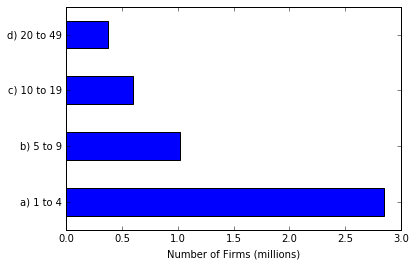

In [49]:
# plot 2013 as bar chart 
fig, ax = plt.subplots()
bdsp[2013].plot.barh(ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Number of Firms (millions)') 

<a id='review'></a>

## Review

We return to the OECD's healthcare data, specifically a subset of their table on the number of doctors per one thousand population.  This loads and cleans the data:  

In [80]:
url1 = 'http://www.oecd.org/health/health-systems/'
url2 = 'OECD-Health-Statistics-2015-Frequently-Requested-Data.xls'
docs = pd.read_excel(url1+url2, 
                     skiprows=3, 
                     usecols=[0, 51, 52, 53, 54, 55, 57],
                     sheetname='Physicians', 
                     na_values=['..'],
                     skip_footer=21) 
# rename country variable 
names = list(docs)
docs = docs.rename(columns={names[0]: 'Country'})
# strip footnote numbers from country names 
docs['Country'] = docs['Country'].str.rsplit(n=1).str.get(0)
docs = docs.head()
docs

,Country,2010,2011,2012,2013,2014,2013 (or nearest year)
0,Australia,NaN,3.31,3.31,3.39,NaN,3.39
1,Austria,4.80,4.84,4.90,4.99,NaN,4.99
2,Belgium,2.92,2.91,2.93,2.95,NaN,2.95
3,Canada,2.37,2.44,2.50,2.55,NaN,2.55
4,Chile,1.43,1.58,1.74,1.88,2.02,1.88


Use this data to:  

* Set the index as `Country`.  
* Construct a horizontal bar chart of the number of doctors in each country in "2013 (or nearest year)".  
* Apply the `drop` method to `docs` to create a dataframe `new` that's missing the last column.  
* *Challenging.* Use `stack` and `unstack` to "pivot" the data so that columns are labeled by country names and rows are labeled by year.  This is challenging because we have left out the intermediate steps.  
* *Challenging.* Plot the number of doctors over time in each country as a line in the same plot. *Hint:* The challenge here is converting the years from strings to integers.  One of those annoying things that show up in applied work.  
* *Challenging and more optional than usual.* Fix the labels on the x axis.  

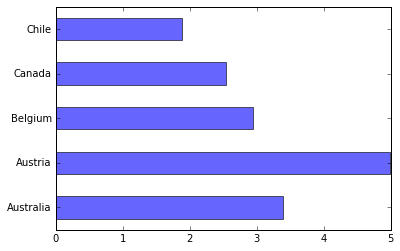

In [95]:
newdocs = docs.copy()
newdocs = newdocs.set_index('Country')
vars = list(newdocs)

fig, ax = plt.subplots()
newdocs[vars[-1]].plot.barh(ax=ax, alpha=0.6)
ax.set_ylabel('')

In [98]:
newdocs

,2010,2011,2012,2013,2014,2013 (or nearest year)
Country,,,,,,
Australia,NaN,3.31,3.31,3.39,NaN,3.39
Austria,4.80,4.84,4.90,4.99,NaN,4.99
Belgium,2.92,2.91,2.93,2.95,NaN,2.95
Canada,2.37,2.44,2.50,2.55,NaN,2.55
Chile,1.43,1.58,1.74,1.88,2.02,1.88


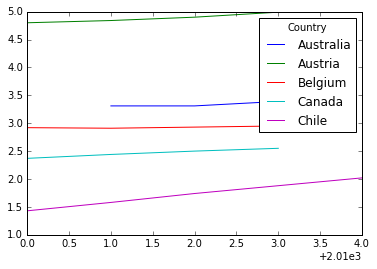

In [96]:
new = newdocs.drop([vars[-1]], axis=1).T
new.plot()

In [100]:
new = newdocs.drop([vars[-1]], axis=1)
new

,2010,2011,2012,2013,2014
Country,,,,,
Australia,NaN,3.31,3.31,3.39,NaN
Austria,4.80,4.84,4.90,4.99,NaN
Belgium,2.92,2.91,2.93,2.95,NaN
Canada,2.37,2.44,2.50,2.55,NaN
Chile,1.43,1.58,1.74,1.88,2.02


In [101]:
new = new.stack()
#['2010', '2011', '2012', '2013', '2014'])
new

Country        
Australia  2011    3.31
           2012    3.31
           2013    3.39
Austria    2010    4.80
           2011    4.84
           2012    4.90
           2013    4.99
Belgium    2010    2.92
           2011    2.91
           2012    2.93
           2013    2.95
Canada     2010    2.37
           2011    2.44
           2012    2.50
           2013    2.55
Chile      2010    1.43
           2011    1.58
           2012    1.74
           2013    1.88
           2014    2.02
dtype: float64

In [104]:
new = new.unstack('Country')

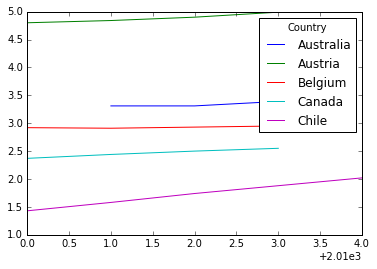

In [105]:
new.plot()